# Pitch & Roll sequence prediction

In [2]:
import gc
import os
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [3]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.0


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 4
Platform: windows
number of workers: 0


# Constants

In [41]:
# change to appropriate location
TRAIN_FOLDER = "../3dmodel/test_4_episode_"
MODEL_NAME = "LSTM_PR_sequence_output"
MODEL_STATE_FOLDER = f"model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"training_results/{MODEL_NAME}"
SAVE_RESULTS = False

In [6]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [7]:
FRAMES_IN = 20
FRAMES_OUT = 60

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'
DEVICE = device

# Load data from episodes

In [8]:
# load all data
episodes = [] # holds pitch, roll, episode number and position within episode number
pr_per_episode = [] # holds all pitch and roll tuples per episode in one row (see pr_per_episode_df)
for ep in range(1, N_EPISODES+1):
    filename = TRAIN_FOLDER+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    pr_in_current_episode = []
    for i in labels:
        pr_in_current_episode.append(labels[i])
        episodes.append(labels[i]+[ep, i])
    pr_per_episode.append(pr_in_current_episode)

In [9]:
p_r_df = pd.DataFrame(episodes)
# p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df = p_r_df.drop([2,3], axis=1)     # drop episode and position_within_episode
p_r_df.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [10]:
pr_per_episode_df = pd.DataFrame(pr_per_episode)
pr_per_episode_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,"[15.9158690209565, 2.3584162956378014]","[14.29592488097425, 1.7003911752437184]","[6.2135895738216185, 1.6113252950233405]","[1.235337361757596, 6.175460896553669]","[1.341678284492817, 3.695467874019875]","[-0.0651516203579112, 3.0756651325514186]","[-4.392773839217525, 0.8726621608752939]","[-4.184235784139164, 0.35570707390756684]","[-3.3195511241318867, 6.666652243167843]","[5.894038319728926, -0.13849362470644613]",...,"[10.389031062517569, 1.5248242575580084]","[-1.2002740520448067, 0.5092731518638726]","[-10.535511299457662, -4.131095631735996]","[-18.896939235154417, -4.945806145463817]","[-22.184256348715486, -1.9589200251876364]","[-0.2044812962373426, 1.503336589150854]","[1.0747428590627885, 10.724272114907427]","[13.3735940647023, 1.5429493384594009]","[11.19363673825518, -0.8486316877453378]","[5.131548017300437, 0.9777773314587621]"
1,"[15.97866748773289, 2.268047343389832]","[9.855846859112509, 1.360887657924949]","[6.105283691039549, 1.5623034265245723]","[1.3507750292502163, 4.69679068181667]","[1.724415511875592, 4.076017413155836]","[0.03351754252109094, 3.1310278711991915]","[-7.604052164296134, 1.8397739918625224]","[-2.5471177738191515, 2.5391520656996245]","[-2.625542432756061, 7.979014181804202]","[6.084213411223707, 0.050736486104279443]",...,"[9.820045568804241, 1.8697905388306129]","[1.4623980360913844, 0.5153293418627053]","[-10.619933291372666, -3.1525508644909594]","[-15.18629041193054, -5.8295536500011895]","[-21.331025702502906, -4.46392562734884]","[-0.980658924236567, 0.000323666141662183]","[1.1033292284517018, 11.141469460921915]","[14.080388870204388, 0.990625450896085]","[11.345563197284712, -0.7964093420118897]","[4.760598735929752, 1.6810054975536355]"
2,"[15.961578354429518, 2.074803789410423]","[6.179635849683839, 0.12110205542910284]","[6.079602606647125, 1.6753055979695541]","[1.3610495547526196, 8.341244726699365]","[0.2675885889498374, 4.800268474629186]","[0.06658679384694029, 3.1533924718627517]","[-5.6663031642145985, 1.2498673085563288]","[-6.884764942802091, 0.6056172923359865]","[-2.0016676178818074, 6.428251747264541]","[6.3722296819184505, 0.18303076698380022]",...,"[9.64882211782213, 1.973062358750971]","[2.395990446922511, 0.4464584900686305]","[-10.690737593629956, -2.750964556154771]","[-14.010888280304924, -6.054184484537745]","[-21.49614211059338, -4.60819715186608]","[-4.0433481914688425, 1.2884030224101293]","[1.1818524982447534, 11.202268389818784]","[14.342162700334297, 0.7591126138013591]","[8.761085355922647, -0.30987522391631195]","[4.628031167442151, 1.9668671637303579]"
3,"[7.69906521829289, 1.5796155014713218]","[8.481780991514256, 0.05603940762328032]","[3.159275826059072, 0.8631695853111513]","[1.049441063612711, 2.2469629763088257]","[0.3593771266476851, 1.8488201505313813]","[-0.07217797069325685, 1.49066178576372]","[-2.60443416001296, 0.27787303957087833]","[-5.056486372756112, 0.3636566403690948]","[-1.834612289840697, 3.3018218740372376]","[2.911777518181313, -0.18950627990486155]",...,"[5.454093028683711, 0.6530340130189489]","[-1.6791362668768735, 0.18489125982090143]","[-5.466481284290821, -2.2171972253493215]","[-11.403407215591903, -1.6377460675585367]","[-9.300110224841715, 0.5591612804484688]","[-0.9304575674455022, 1.7758436346746147]","[0.5600581696638561, 4.948483152731639]","[6.361704787294284, 1.072871920838734]","[6.398844794679874, -0.44728280852408636]","[2.689249101248651, 0.22945817745416852]"
4,"[7.810402424405974, 1.4887826299683204]","[7.868472692729423, 0.18104613012244872]","[3.1332145989506532, 0.9057401800562839]","[0.9454851575582939, 2.1807891154219803]","[0.49654637500602317, 1.7821752200352163]","[-0.04738833270922448, 1.498974979757272]","[-2.617495189253317, 0.3204662326372101]","[-4.8539576034868945, 0.6764536111050119]","[-1.7194979891165945, 3.217247483526378]","[2.9227715614240943, -0.18400777751980293]",...,"[5.2915481868157475, 0.7305929454785594

In [11]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to normalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [12]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df.head()

,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


# Create input and output sequences

In [14]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, 
        output_feature_columns = ["pitch", "roll"],
        input_feature_columns = ["pitch", "roll"], 
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT, 
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):
        for l in range(episode_length-output_sequence_length-input_sequence_length+1):

            i = l+(n*episode_length)

            # sequence = input_data.iloc[i:i+input_sequence_length][input_feature_columns]
            sequence = input_data.iloc[i:i+input_sequence_length].transpose()

            target_position = i + input_sequence_length
            # target = input_data.iloc[target_position:target_position+output_sequence_length][output_feature_columns]
            target = input_data.iloc[target_position:target_position+output_sequence_length].transpose()

            sequences.append((sequence, target))

    return sequences

In [15]:
input_features = ["pitch", "roll"]
target_features = ["pitch", "roll"]
all_sequences = create_sequences(p_r_df, target_features, input_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [16]:
len(all_sequences), all_sequences[0][0].shape, all_sequences[0][1].shape 

(173340, (2, 20), (2, 60))

In [17]:
all_sequences[0][0]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
pitch,0.176843,0.158844,0.069040,0.013726,0.014908,-0.000724,-0.048809,-0.046492,-0.036884,0.065489,0.029492,-0.003735,0.152513,0.091190,0.093264,-0.012752,0.095015,0.162501,0.103608,0.077369
roll,0.026205,0.018893,0.017904,0.068616,0.041061,0.034174,0.009696,0.003952,0.074074,-0.001539,0.056080,0.063161,0.047668,0.016488,-0.019758,0.099169,0.120886,0.146725,0.127897,0.098694


In [18]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 138672 | Test size: 34668
[167621, 29184, 6556, 72097, 64196, 58513, 36579, 26868, 142964, 22790]
[1, 3, 4, 5, 131076, 131085, 17, 18, 131089, 21]


In [19]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/138672 [00:00<?, ?it/s]

  0%|          | 0/34668 [00:00<?, ?it/s]

True
138672 (2, 20) (2, 60)
34668 (2, 20) (2, 60)


## Pytorch Dataset and DataLoader

In [27]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            labels = torch.Tensor(labels.to_numpy())
        )

In [28]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [22]:
# setup datamodule
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

## Model import

In [23]:
from models.LSTM_PR_sequence import LSTM_seq2seq

In [24]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 2, 20]) torch.Size([64, 2, 60])


In [25]:
lstm_seq2seq = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)

outputs = lstm_seq2seq.forward(x_train)
# output should be a sequence of pitch and roll (2 features)
outputs.shape

torch.Size([64, 2, 60])

### Load model state

In [26]:
filename = f'{MODEL_STATE_FOLDER}/PR_LSTM_sequence_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda() 

loaded_model.eval()

LSTM_seq2seq(
  (encoder): Encoder(
    (encoder_lstm): LSTM(20, 300, batch_first=True)
  )
  (decoder): Decoder(
    (decoder_lstm): LSTM(300, 300, batch_first=True)
    (decoder_fc_1): Linear(in_features=300, out_features=150, bias=True)
    (decoder_fc_2): Linear(in_features=150, out_features=60, bias=True)
  )
)

# Testing

In [29]:
# get first I/O-sequence of test dataset for visualizing a prediction
for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

# batch size = 1 for testing dataset
print(x_test.shape, y_test.shape)

torch.Size([1, 2, 20]) torch.Size([1, 2, 60])


In [30]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [0.1086, 0.0554, -0.0347, -0.0513, -0.0258, 0.0533, 0.1364, 0.1797, 0.1421, 0.098, 0.0654, 0.0525, 0.0459, 0.0554, 0.0496, 0.0303, 0.0309, 0.0478, 0.0816, 0.1002, 0.0912, 0.0115, -0.0772, -0.098, -0.0876, -0.0371, 0.0809, 0.1766, 0.2565, 0.2561, 0.2368, 0.1852, 0.1274, 0.1002, 0.0931, 0.0897, 0.0488, 0.0137, 0.0117, -0.0104, -0.027, -0.0105, 0.0098, 0.0651, 0.1222, 0.1349, 0.128, 0.0642, 0.0137, -0.0142, -0.0434, -0.0354, 0.0011, 0.0016, -0.053, -0.1089, -0.1194, -0.0361, 0.0351, 0.062]
real pitch:	 [0.0615, 0.1166, -0.1029, -0.039, -0.0965, 0.115, 0.0672, 0.1892, 0.1413, 0.0972, 0.0782, -0.0112, 0.0431, 0.1098, 0.081, 0.0346, 0.0441, 0.0603, 0.0499, -0.0585, 0.0075, 0.0952, -0.1104, -0.1677, -0.1942, 0.0601, 0.1967, 0.1765, 0.1818, 0.1645, 0.2538, 0.2093, 0.1261, -0.0085, 0.1973, 0.0156, 0.0242, 0.059, 0.1047, -0.0406, 0.0331, -0.1455, 0.0176, 0.0285, 0.1294, 0.1163, 0.0226, 0.0171, -0.066, 0.0246, -0.1826, 0.0472, -0.0261, -0.0216, -0.0763, -0.1334, -0.1328, 0.0595, 

(torch.Size([2, 20]), torch.Size([2, 60]), torch.Size([2, 60]))

### Prediction vs. real on first test I/O-sequence

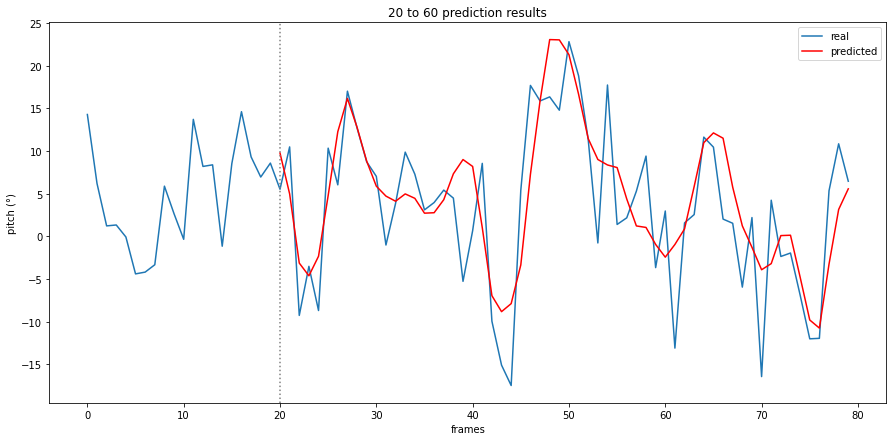

In [31]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(frames, torch.cat((input_sequence[0].apply_(denorm_pr), output_sequence[0].apply_(denorm_pr))), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
if SAVE_RESULTS:
    plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

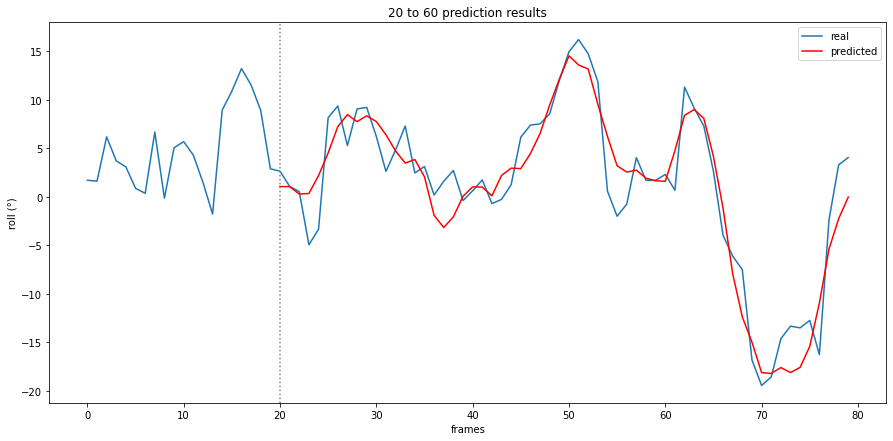

In [32]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(frames, torch.cat((input_sequence[1].apply_(denorm_pr), output_sequence[1].apply_(denorm_pr))), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[1].apply_(denorm_pr), color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
if SAVE_RESULTS:
    plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

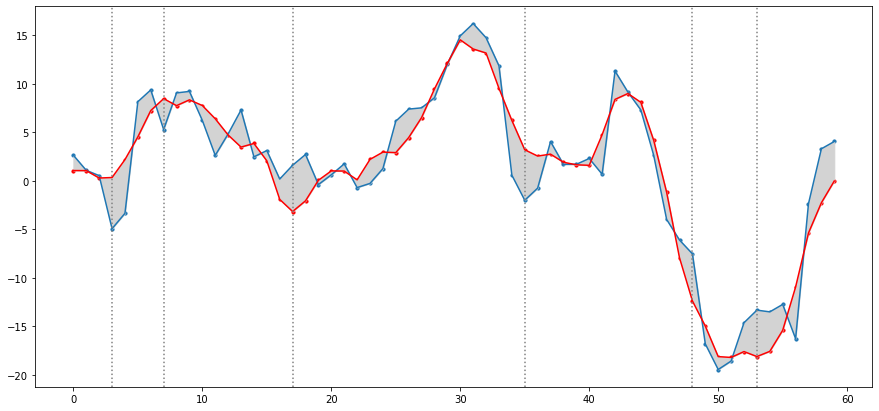

In [71]:
# area between graphs
output = output_sequence[1].numpy()
predic = predicted_sequence[1].numpy()
x = np.arange(0, FRAMES_OUT)

plt.figure(figsize=(15,7))
plt.plot(output)
plt.plot(predic, color="r")
plt.scatter(np.arange(60), output, s=10)
plt.scatter(np.arange(60), predic, s=10, color="r")
plt.axvline(x=3, color='grey', linestyle='dotted')
plt.axvline(x=7, color='grey', linestyle='dotted')
plt.axvline(x=17, color='grey', linestyle='dotted')
plt.axvline(x=35, color='grey', linestyle='dotted')
plt.axvline(x=48, color='grey', linestyle='dotted')
plt.axvline(x=53, color='grey', linestyle='dotted')
plt.fill_between(x, output, predic, color="lightgrey")
plt.show()

In [36]:
# function to calculate area between 2 points on 2 lines
def calculate_area(input1, input2):
    if(len(input1) != len(input2)):
        return None
    res = []
    for i in range(len(input1)-1):
        t0 = math.sqrt((input1[i] - input2[i])**2)
        t1 = math.sqrt((input1[i+1] - input2[i+1])**2)

        res.append(t0+t1)

    return np.array(res)

In [60]:
# function to calculate gradient difference between two points on two lines
def calculate_gradient(input1, input2):
    if(len(input1) != len(input2)):
        return None
    res = [0]
    for i in range(len(input1)-1):
        g0 = input1[i+1] - input1[i]
        g1 = input2[i+1] - input2[i]

        res.append(abs(g0-g1))

    return np.array(res)

In [37]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [73]:
import similaritymeasures
x = np.arange(0, FRAMES_OUT)
dtw, d = similaritymeasures.dtw([x, output],[x, predic])
dtw

22.404900252139832

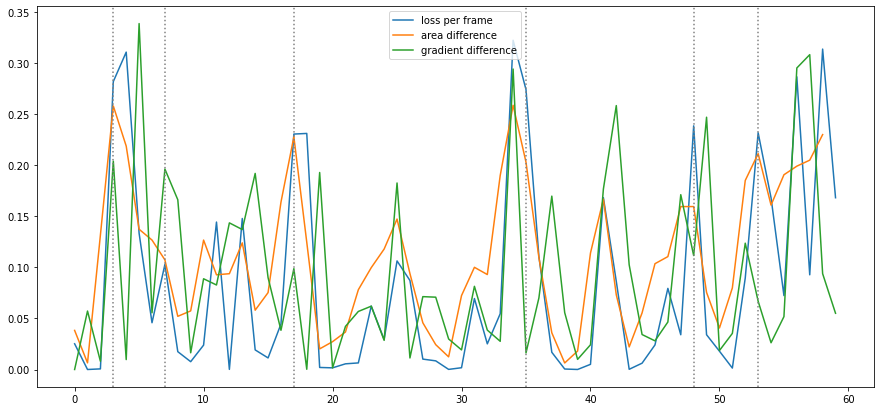

In [62]:
pr = 1
lpf = loss_per_frame(predicted_sequence[pr], output_sequence[pr])
area = calculate_area(output, predic)
grad = calculate_gradient(output, predic)
plt.figure(figsize=(15,7))
plt.plot(lpf/np.linalg.norm(lpf), label="loss per frame")
plt.plot(area/np.linalg.norm(area), label="area difference")
plt.plot(grad/np.linalg.norm(grad), label="gradient difference")
plt.axvline(x=3, color='grey', linestyle='dotted')
plt.axvline(x=7, color='grey', linestyle='dotted')
plt.axvline(x=17, color='grey', linestyle='dotted')
plt.axvline(x=35, color='grey', linestyle='dotted')
plt.axvline(x=48, color='grey', linestyle='dotted')
plt.axvline(x=53, color='grey', linestyle='dotted')
plt.legend()
plt.show()

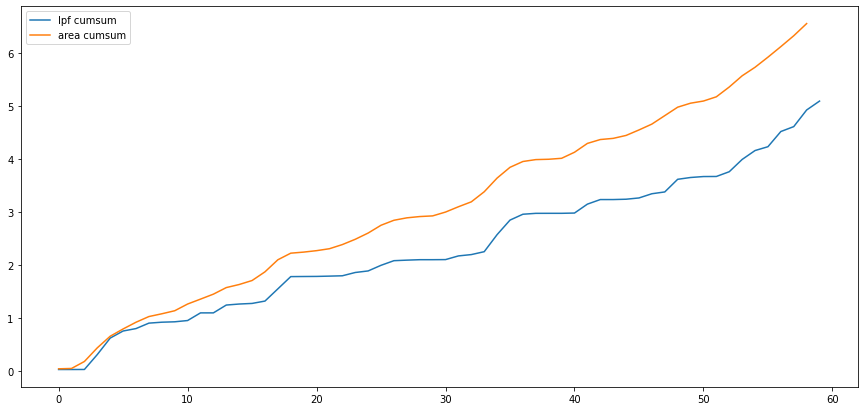

In [39]:
plt.figure(figsize=(15,7))
plt.plot(np.cumsum(lpf/np.linalg.norm(lpf)), label="lpf cumsum")
plt.plot(np.cumsum(area/np.linalg.norm(area)), label="area cumsum")
plt.legend()
plt.show()

### Full test loop

In [46]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()

        output = loaded_model(x_test)

        # squeeze out batch size which is = 1 for test dataset
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.squeeze(0))

  0%|          | 0/34668 [00:00<?, ?it/s]

In [47]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch sequence
# Predictions[0][1] = roll sequence

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([60]), torch.Size([60]), torch.Size([60]), torch.Size([60]))

### Average loss-per-frame over all datapoints

In [49]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

  0%|          | 0/34668 [00:00<?, ?it/s]

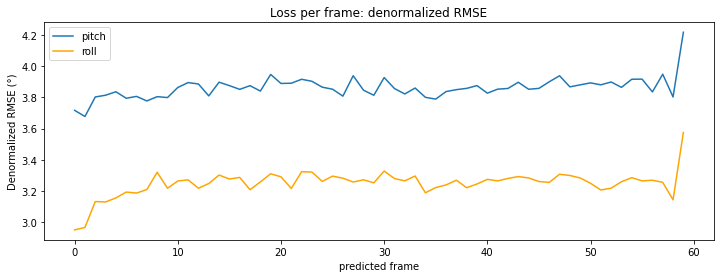

In [51]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(12, 4))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
if SAVE_RESULTS:
    plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### MSE results pitch

In [52]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(pitch_label[i], pitch_predictions[i]).item()
    loss0 += criterion(pitch_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Pitch prediction
   MSE: 0.00184
   RMSE: 0.0429
   RMSE denorm: 3.86°
Zero prediction
   MSE 0: 0.00483
   RMSE 0: 0.0695
   RMSE denorm: 6.26°
Improvement on zero prediction:
   MSE delta%: 262.5 %
   RMSE delta%: 162.0 %


### MSE results roll

In [53]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = 0
loss0 = 0

for i in range(n):
    loss += criterion(roll_label[i], roll_predictions[i]).item()
    loss0 += criterion(roll_label[i], loss0_tensor).item()

mse = round(loss/n, 5)
rmse = round(math.sqrt(loss/n), 4)
mse0 = round(loss0/n, 5)
rmse0 = round(math.sqrt(loss0/n), 4)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.0013
   RMSE: 0.0361
   RMSE denorm: 3.25°
Zero prediction
   MSE 0: 0.00688
   RMSE 0: 0.083
   RMSE denorm: 7.47°
Improvement on zero prediction:
   MSE delta%: 529.23 %
   RMSE delta%: 229.92 %
